In [21]:
from IPython.display import display, Math, Latex, HTML

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb
import os

gum.config['notebook','default_graph_size'] = 10

def common_data(list1, list2): 
    result = False
    # traverse in the 1st list 
    for x in list1: 
        # traverse in the 2nd list 
        for y in list2: 
            # if one common 
            if x == y: 
                result = True
                return result 


def getAncestors(cm,varSet):
    ancestors=varSet

    while len(varSet)>0:
        newparents=cm.parents(varSet[0])
        newparents = [i for b in map(lambda x:[x] if not isinstance(x, list) else x, newparents) for i in b]
        newparents = [cm.names()[i] for i in newparents] 
        ancestors=ancestors+newparents
        varSet=varSet+newparents
        varSet.remove(varSet[0])
    return(ancestors)

def dSeparation(cm, varSet1, varSet2, evs):
    cmcopy=gum.fastBN("A")
    cmcopy.erase("A")
    [ cmcopy.add(name, 2) for name in cm.names()]
    for link in cm.arcs():
        cmcopy.addArc(*link)
    l1=cmcopy.names()
    l2=getAncestors(cmcopy,varSet1+varSet2+evs)
    #print(l2)
    l3 = [x for x in l1 if x not in l2]
    for i in l3:
        cmcopy.erase(i)
    m=cmcopy.moralGraph()
    if len(evs)>0:
        for i in evs:
            m.eraseNode(cmcopy.idFromName(i))
    #gnb.sideBySide(m)
    connComp=m.connectedComponents()
    #print(connComp)
    idVarSet1=[]
    idVarSet2=[]
    for i in varSet1:
        idVarSet1.append(cmcopy.idFromName(i))
    for i in varSet2:
        idVarSet2.append(cmcopy.idFromName(i))
    dSeparated=True
    for i in connComp:
        connCompSet=connComp[i]
        connCompSet= [i for b in map(lambda x:[x] if not isinstance(x, list) else x, connCompSet) for i in b]
        if common_data(connCompSet, idVarSet1) and common_data(connCompSet, idVarSet2):
            dSeparated=False
    del cmcopy
    return dSeparated


In [22]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "graph.png")

# 1) Structure of the network

\textbf{List at least 10 binary variables all measurable involved in the problem:}
    The binary nature of some of the variables could be unclear. The following list enumerates the variables, explain how they could be binary and gives an abbreviation for each one of them, useful for undermentioned considerations.
    \begin{enumerate}
        \item [BPa] Back pain: more than 3 pain spikes during the day, for example in the lumbar region
        \item [BPo] Bad Posture: inadvertently slouching the majority of the time
        \item [LS] Long computer sessions: more than 8 hours per day on average without breaks that take more than 30 minutes
        \item [SD] Sleep Deprivation: less than k hours of sleep per night on average, with k ranging from 6 to 8 depending on the person
        \item [H] Headache
        \item [D] Dehydration: drinking less than 2 liters of water per day on average
        \item [G] Gym: at least 3 day per week of gym activity
        \item [S] Stress: molecular bio-markers blood scan in combination with responses to questionnaires to gauge it with a prefixed threshold for both
        \item [R] Running: going out for a run longer than 30 minutes at least 3 times per week
        \item [L] Laziness: apparently it is measurable with self-regulation,  by  using  heart  rate  variability  (HRV)  biofeedback  technique \cite{lazy} with some prefixed threshold
        \item [BM] Body Movement: walking and streching sufficiently (ie. x times per day, y minutes per day)
    \end{enumerate}

\textbf{State which is the objective of the network: for instance, highlight a couple of situations in which decision making could be difficult and in which the graph could provide valuable indications} The objective of this network is to study and model the psycho-physiological profile of a data analyst, even though it remains applicable to any computer scientist. Two root causes are identified, represented as source nodes: long sessions on the personal computer and a person's own laziness. We will ignore their respective causes, but the former could occur due to work of academic duties, while the latter is a personal trait that is developed growing up, probably caused by education, social context and historical period. Furthermore, a final effect is identified: stress. This, in turn, could cause other psycho-physiological problems, but we are going to ignore it as it goes beyond the scope of this simple model. This causal model allows us to pose some interesting questions like: 
    \begin{enumerate}
        \item What is the major cause of a headache? 
        \item What helps more to eliminate the stress, doing gym or just running?
        \item What should I focus on to actively improve my well-being?
    \end{enumerate}

\textbf{Explaining how you decide the arcs orientation, in case they are not self-explaining} 
    \begin{enumerate}
        \item [LS \rightarrow BPo] Human body is not designed for sitting for prolonged times. Moreover, a personal computer without a monitor at the proper height (eg. a laptop) can cause a severe slouching.
        \item [G \rightarrow R] Usually people who go running do not feel the need to also go to gym. Vice-versa, if an individual goes to gym, there is a good chance he will use the treadmill at the start and/or at the end of the workout session.
        \item [G,R \rightarrow S, D \leftarrow H] It's well known that running andhttps://www.overleaf.com/project/5e1853468eebb700011efe1e working out have a positive effect on the elimination of stress, even though both activities consume a significant amount of water inside the body thought sweat and assimilation.
        \item [G,R \rightarrow SD] They also increase the quality of night's sleep, weakening the negative effects of sleep deprivation. 
    \end{enumerate}

In [23]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "equivalent.png")

\textbf{Which arrows can be reversed without being detectable by a statistical test? Explain why} 
    \begin{enumerate}
        \item [Red arrows] Would destroy a V-structure if reversed
        \item [Green arrows] Would create a cycle if reversed
        \item [Yellow arrows] Would create a V-structure if reversed
        \item [Grey bidirected arrows] They can be reverted to create an equivalent model
    \end{enumerate}

In [24]:
!pip install networkx

/bin/sh: pip: command not found


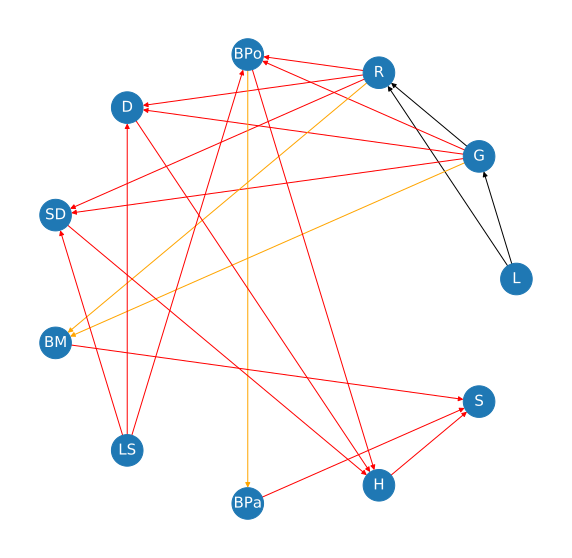

In [25]:
import itertools
import networkx as nx
import matplotlib.pyplot as plt
G = nx.DiGraph()
G.add_edges_from(
    [('L', 'G'), ('L', 'R'),  ('G', 'BPo'), ('G', 'R'), ('G', 'D'), ('G', 'SD'), ('G', 'BM'), 
     ('R', 'BPo'),('R', 'D'), ('R', 'SD'), ('R', 'BM'), ('LS', 'BPo'), ('LS', 'D'), ('LS', 'SD'),
    ('BPo', 'BPa'), ('BPo', 'H'), ('D', 'H'), ('SD', 'H'), ('BM', 'S'), ('BPa', 'S'),  ('H', 'S')])
for u, v, d in G.edges(data=True):
    d['reversable'] = 'black'

Grev = G.reverse(copy=True)
for node in Grev.nodes():
    # what would create a V-structure
    for neighbor in Grev.neighbors(node):
        H = Grev.copy()
        attrs = Grev[node][neighbor]
        H.remove_edge(node,neighbor)
        H.add_edge(neighbor,node,reversable=attrs['reversable'])
        psp2 = list(itertools.combinations(list(H.neighbors(neighbor)), 2))
        for a, b in psp2:
            if not (H.has_edge(a,b) or H.has_edge(b,a)):
                Grev[node][neighbor]['reversable'] = 'orange'
    
    # what would destroy a V-structure
    psp = list(itertools.combinations(list(Grev.neighbors(node)), 2))
    for a, b in psp:
        if not (Grev.has_edge(a,b) or Grev.has_edge(b,a)):
            Grev[node][a]['reversable'] = 'red'
            Grev[node][b]['reversable'] = 'red'
    
# what would create a cycle?
for node in Grev.nodes():
    for neighbor in Grev.neighbors(node):
        if Grev[node][neighbor]['reversable'] == 'black':
            H = Grev.copy()
            attrs = Grev[node][neighbor]
            H.remove_edge(node,neighbor)
            H.add_edge(neighbor,node,reversable=attrs['reversable'])
            try:
                find_cycle(H)
                Grev[node][neighbor]['reversable'] = 'green'
            except:
                pass
                
G = Grev.reverse(copy=True)
edges,reversable = zip(*nx.get_edge_attributes(G,'reversable').items())

fig, ax = plt.subplots(figsize=(10,10))
nx.draw_shell(G,with_labels=True, edgelist=edges, edge_color=reversable, 
              font_color='white', node_size=1000, font_size=15)
ax.set_facecolor((1, 1, 1, 0))
fig.set_facecolor((1, 1, 1, 0))

This algorithm confirms the equivalent models illustrated in the previous answer.

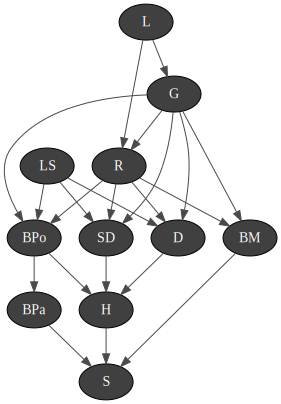

In [26]:
#construct network of Monty Hall
m0 = gum.fastBN("L->G->R->SD->H->S<-BPa<-BPo<-LS;SD<-LS->D->H;L->R->BPo->H;R->D<-G->SD;R->BM->S;G->BM;G->BPo",2)
gnb.showBN(m0,size=100)

\textbf{Identify at least 4 couple of nodes (the node of each couple should be not directly linked to each other) and analyze their d-separation properties possibly conditioning on others.}
\begin{enumerate}
        \item [BPa, H] D-separated when conditioning on {BPo}
        \item [BPa, BM] D-separated when conditioning on {R, G}
        \item [LS, R] D-separated when conditioning on {}
        \item [LS, BPa] D-separated if conditioning on {BPo}
    \end{enumerate}
   \textbf{Discuss how d-connected variables are in fact dependent in the real problem, while d-separated variables are instead independent in the real problem.} For example, an indivudal that has backpain does not tell anything on the probabilty of him having an headache, provided that I know already if I have bad posture. If I were to condition {BPa,H} on {S}, therefore opening a path (thus d-connecting them) it would still make sense: knowing that an individual is stressed and that he has back pain I could infer something about the probability of him having a headache.

In [27]:
# Code equivalent check
print(dSeparation(m0,["BPa"], ["H"], ['BPo']))
print(dSeparation(m0,["BPa"], ["BM"], ['R','G']))
print(dSeparation(m0,["LS"], ["R"], []))
print(dSeparation(m0,["LS"], ["BPa"], ['BPo']))

True
True
True
True


# 2) Conditional Probability Tables

\textbf{Explain how do you fill the probability tables for the nodes.} For instance:
\begin{enumerate}
        \item you have retrieved information from the internet (or other sources)
        \item you have estimated the CPTs froma database
        \item you have relied on your personal experience/common sense
    \end{enumerate}

I have relied on my personal experience/common sense for the most of the nodes in the model. In particular, I observed that long study sessions are more likely to occur during exam sessions, retake periods and midterm periods, and a good estimate could be 1 month per year ($P \approx 0.1$). Regarding the rest, I made these assumptions:
\begin{enumerate}
        \item Running and Gym decrease the probabilty of negative effects, except for Dehydratrion which is more complex and would require a more advanced, specific analysis, as they both cause it (sweat) but also prevent it (it would be easier to remember to drink frequently)
        \item All the bad conditions of the middle nodes {SD,D,BPo) increase the probabilty of having an headache and back pain, which in turn could cause stress
    \end{enumerate}
  

In [28]:
m0.cpt("L")[:]=[0.5, 0.5]

m0.cpt("G")[{'L':0}]=[0.1, 0.9]
m0.cpt("G")[{'L':1}]=[0.9, 0.1]

m0.cpt("LS")[:]=[0.9, 0.1]

m0.cpt("BPo")[{'G':0, 'LS':0, 'R':0}]=[0.5, 0.5]
m0.cpt("BPo")[{'G':0, 'LS':0, 'R':1}]=[0.8, 0.2]
m0.cpt("BPo")[{'G':0, 'LS':1, 'R':0}]=[0.1, 0.9]
m0.cpt("BPo")[{'G':0, 'LS':1, 'R':1}]=[0.7, 0.3]
m0.cpt("BPo")[{'G':1, 'LS':0, 'R':0}]=[0.8, 0.2]
m0.cpt("BPo")[{'G':1, 'LS':0, 'R':1}]=[0.9, 0.1]
m0.cpt("BPo")[{'G':1, 'LS':1, 'R':0}]=[0.9, 0.1]
m0.cpt("BPo")[{'G':1, 'LS':1, 'R':1}]=[0.9, 0.1]

m0.cpt("SD")[{'G':0, 'LS':0, 'R':0}]=[0.4, 0.6]
m0.cpt("SD")[{'G':0, 'LS':0, 'R':1}]=[0.7, 0.3]
m0.cpt("SD")[{'G':0, 'LS':1, 'R':0}]=[0.3, 0.7]
m0.cpt("SD")[{'G':0, 'LS':1, 'R':1}]=[0.6, 0.4]
m0.cpt("SD")[{'G':1, 'LS':0, 'R':0}]=[0.7, 0.3]
m0.cpt("SD")[{'G':1, 'LS':0, 'R':1}]=[0.8, 0.2]
m0.cpt("SD")[{'G':1, 'LS':1, 'R':0}]=[0.7, 0.3]
m0.cpt("SD")[{'G':1, 'LS':1, 'R':1}]=[0.9, 0.1]

# maybe need to adjust better these probabilities
m0.cpt("D")[{'G':0, 'LS':0, 'R':0}]=[0.5, 0.5]
m0.cpt("D")[{'G':0, 'LS':0, 'R':1}]=[0.5, 0.5]
m0.cpt("D")[{'G':0, 'LS':1, 'R':0}]=[0.5, 0.5]
m0.cpt("D")[{'G':0, 'LS':1, 'R':1}]=[0.5, 0.5]
m0.cpt("D")[{'G':1, 'LS':0, 'R':0}]=[0.5, 0.5]
m0.cpt("D")[{'G':1, 'LS':0, 'R':1}]=[0.5, 0.5]
m0.cpt("D")[{'G':1, 'LS':1, 'R':0}]=[0.5, 0.5]
m0.cpt("D")[{'G':1, 'LS':1, 'R':1}]=[0.5, 0.5]

m0.cpt("BM")[{'G':0, 'R':0}]=[0.8, 0.2]
m0.cpt("BM")[{'G':0, 'R':1}]=[0.1, 0.9]
m0.cpt("BM")[{'G':1, 'R':0}]=[0.2, 0.8]
m0.cpt("BM")[{'G':1, 'R':1}]=[0.,  1.]

m0.cpt("BPa")[{'BPo':0}]=[0.8, 0.2]
m0.cpt("BPa")[{'BPo':1}]=[0.3, 0.7]

m0.cpt("H")[{'BPo':0, 'SD':0, 'D':0}]=[0.9, 0.1]
m0.cpt("H")[{'BPo':0, 'SD':0, 'D':1}]=[0.8, 0.2]
m0.cpt("H")[{'BPo':0, 'SD':1, 'D':0}]=[0.8, 0.2]
m0.cpt("H")[{'BPo':0, 'SD':1, 'D':1}]=[0.7, 0.3]
m0.cpt("H")[{'BPo':1, 'SD':0, 'D':0}]=[0.8, 0.2]
m0.cpt("H")[{'BPo':1, 'SD':0, 'D':1}]=[0.7, 0.3]
m0.cpt("H")[{'BPo':1, 'SD':1, 'D':0}]=[0.7, 0.3]
m0.cpt("H")[{'BPo':1, 'SD':1, 'D':1}]=[0.6, 0.4]

m0.cpt("S")[{'BPa':0, 'H':0, 'BM':0}]=[0.8,0.2]
m0.cpt("S")[{'BPa':0, 'H':0, 'BM':1}]=[0.9,0.1]
m0.cpt("S")[{'BPa':0, 'H':1, 'BM':0}]=[0.7,0.3]
m0.cpt("S")[{'BPa':0, 'H':1, 'BM':1}]=[0.9,0.1]
m0.cpt("S")[{'BPa':1, 'H':0, 'BM':0}]=[0.8,0.2]
m0.cpt("S")[{'BPa':1, 'H':0, 'BM':1}]=[0.7,0.3]
m0.cpt("S")[{'BPa':1, 'H':1, 'BM':0}]=[0.7,0.3]
m0.cpt("S")[{'BPa':1, 'H':1, 'BM':1}]=[0.7,0.3]


m0.cpt("R")[{'L':0, 'G':0}]=[0.4, 0.6]
m0.cpt("R")[{'L':0, 'G':1}]=[0.1, 0.9]
m0.cpt("R")[{'L':1, 'G':0}]=[0.7, 0.3]
m0.cpt("R")[{'L':1, 'G':1}]=[0.9, 0.1]

# 3) Causal Inference

Choose one pair of variables. The pair must be made up of a variable X with at least one parent and another variable Y of the graph such that there is (at least) a causal path from X to Y.
For the pair (X,Y) perform:
\begin{enumerate}
    \item Calculate the causal effect of X on Y
    \item Identify possible confounders between X and Y
    \item Would it be practically possible in your specific problem to perform also a randomized controlled study to disentangle the causal effect between the variables from their correlation?
    \item Compute the ACE of X on Y.
\end{enumerate}

I choose $P(S=s|do(G=g))= \sum_{l} P(S=s|G=g,L=l)P(L=l)$

In [29]:
cm0 = csl.CausalModel(m0)
cslnb.showCausalImpact(cm0, "S", doing="G")

In [30]:
x = csl.causalImpact(cm0,on="S",doing="G")[1]
print("ACE(S=1):", x[1][1]-x[0][1])

ACE(S=1): -0.035524


The causal effect is shown here. The confounder (backdoor) is L. A randomized controlled study that used a lot of people (50% lazy and 50% not lazy) could naturally filter out the confounding effect of being lazy. 
$ACE = P(Y=1|do(X=1)) - P(Y=1|do(X=0)) = 0.35524$ 

\textbf{ Choose another pair of variable (X,Y) (it can be also the previous one) and choose another variable C such that it is possible to calculate the c-specific effect of X on Y and calculate it}

I choose $P(BPa=bpa|do(R=R), L=l)= \sum_{g} P(S=s|R=r,G=g,L=l)P(G=g|L=l)$

Let's double check with pyAgrum internal function:

\textbf{ Identify a minimal set of variables that must be measured in order to estimate the c-specific effect of X on Y.}
While pyAgrum internal function decided to use {BM,BPa,BPo,D,H,L,R,SD}, the one that I've previously used already constitutes a minimal set (blocking on L is necessary and sufficient): {G,S,L,LS}

\textbf{ Choose a function g and compute the effect of the conditional intervention of X=g(C) on Y.}
        
$P(BPa=bpa|do(R=fun(L))=\sum_{l} P(BPa=bpa|do(R=fun(l)),L=l)P(L=l)$
$=\sum_{l} \sum_{g} P(BPa=bpa|R=r,L=l,G=g)P(G=g|L=l)P(L=l)$
$=\sum_{l,g} P(BPa=bpa|R=r,L=l,G=g)P(G=g,L=l)$

### L-specific effect

In [31]:
cause = "R"
target = "BPa"
specific = "L"
backdoor = "G"

ie=gum.LazyPropagation(m0)
ie.addJointTarget({target,cause,specific, backdoor})
ie.makeInference()
pYgivenXZC=ie.evidenceJointImpact([target],[cause,specific, backdoor])
pZgivenCX=ie.evidenceJointImpact([backdoor],[specific])

result = pYgivenXZC.extract({backdoor:0}) * pZgivenCX.extract({backdoor:0})
result += pYgivenXZC.extract({backdoor:1}) * pZgivenCX.extract({backdoor:1})
gnb.sideBySide(result.putFirst(target),captions=["$\\forall {},{},{} P({}|do({}),{})$".format(target,cause, specific,target,cause, specific)])

In [33]:
# ie=gum.LazyPropagation(m0)
# ie.addJointTarget({target,cause,specific})
# ie.makeInference()
# pRgivenDA=ie.evidenceJointImpact([target],[specific, cause])

def g(x):
    return x

expected_value=0
for i in [0,1]:
    firstprob = result.extract({cause:g(0), target:i})
    expected_value=expected_value+firstprob[i]*m0.cpt(specific)[i]
expected_value

0.5700000000000001

Then we use it to calculate the conditional intervention wanted:

$P(Y|do(X=g(Z))=\sum_{z}P(Y|do(X=x), Z=z)|_{x=g(z)}P(Z=z)$

# References

(<a id="cit-lazy" href="#call-lazy">RUSYAINI, 2015</a>) WAN RUSYAINI, ``_MEASURING LAZINESS THROUGH SELF-REGULATION USING HEART RATE VARIABILITY (HRV) BIOFEEDBACK_'', January 2015.

